<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/examples/multi_modal/multi_modal_pdf_tables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Modal on PDF's with tables.


One common challenge with RAG (`Retrieval-Augmented Generation`) involves handling PDFs that contain tables. Parsing tables in various formats can be quite complex.

However, Microsoft's newly released model, [`Table Transformer`](https://huggingface.co/microsoft/table-transformer-detection), offers a promising solution for detecting tables within images.

In this notebook, we will demonstrate how to leverage the `Table Transformer` model in conjunction with GPT4-V to yield better results for images containing tables.

The experiment is divided into the following parts and we compared those 4 options for extracting table information from PDFs:

1. Retrieving relevant images (PDF pages) and sending them to GPT4-V to respond to queries.
2. Regarding every PDF page as an image, let GPT4-V do the image reasoning for each page. Build Text Vector Store index for the image reasonings. Query the answer against the `Image Reasoning Vectore Store`.
3. Using `Table Transformer` to crop the table information from the retrieved images and then sending these cropped images to GPT4-V for query responses.
4. Applying OCR on cropped table images and send the data to GPT4/ GPT-3.5 to answer the query.

#### Setup

In [ ]:
!pip install llama-index qdrant_client pyMuPDF tools frontend git+https://github.com/openai/CLIP.git easyocr

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch
import io
from PIL import Image, ImageDraw
import numpy as np
import csv
import pandas as pd

from torchvision import transforms

from transformers import AutoModelForObjectDetection
import torch
import openai
import os
import fitz

device = "cuda" if torch.cuda.is_available() else "cpu"

OPENAI_API_TOKEN = "sk-<your-openai-api-token>"
openai.api_key = OPENAI_API_TOKEN

Download Llama2 paper for the experiments.

In [ ]:
!wget --user-agent "Mozilla" "https://arxiv.org/pdf/2307.09288.pdf" -O "llama2.pdf"

Here we convert each of the Llama2 paper pdf page to images for indexing.

In [ ]:
pdf_file = "llama2.pdf"

# Split the base name and extension
output_directory_path, _ = os.path.splitext(pdf_file)

if not os.path.exists(output_directory_path):
    os.makedirs(output_directory_path)

# Open the PDF file
pdf_document = fitz.open(pdf_file)

# Iterate through each page and convert to an image
for page_number in range(pdf_document.page_count):
    # Get the page
    page = pdf_document[page_number]

    # Convert the page to an image
    pix = page.get_pixmap()

    # Create a Pillow Image object from the pixmap
    image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    # Save the image
    image.save(f"./{output_directory_path}/page_{page_number + 1}.png")

# Close the PDF file
pdf_document.close()

Display the images.

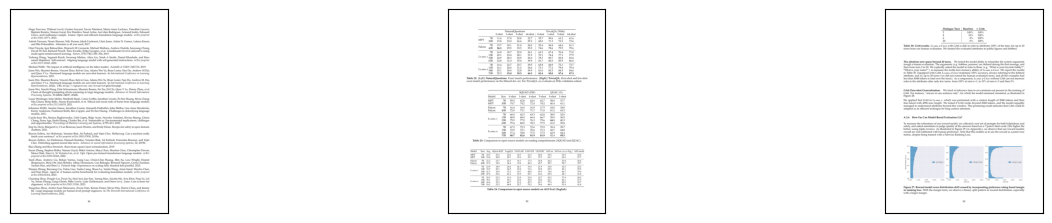

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

image_paths = []
for img_path in os.listdir("./llama2"):
    image_paths.append(str(os.path.join("./llama2", img_path)))


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(3, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break


plot_images(image_paths[9:12])

## Experiment-1: Retrieving relevant images (PDF pages) and sending them to GPT4-V to respond to queries.

We will now index the images with `qdrant` vector store using our `MultiModalVectorStoreIndex` abstractions.

In [ ]:
import qdrant_client
from llama_index import (
    ServiceContext,
    SimpleDirectoryReader,
)
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index import VectorStoreIndex, StorageContext
from llama_index.indices.multi_modal.base import MultiModalVectorStoreIndex
from llama_index.schema import ImageDocument

from llama_index.response.notebook_utils import display_source_node
from llama_index.schema import ImageNode

In [ ]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal

openai_mm_llm = OpenAIMultiModal(
    model="gpt-4-vision-preview", api_key=OPENAI_API_TOKEN, max_new_tokens=1500
)

Build the Multi-Modal retriever.

In [ ]:
# Read the images
documents_images = SimpleDirectoryReader("./llama2/").load_data()

# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_index")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)
storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

# Create the MultiModal index
index = MultiModalVectorStoreIndex.from_documents(
    documents_images,
    storage_context=storage_context,
)

retriever_engine = index.as_retriever(image_similarity_top_k=2)

In [ ]:
from llama_index.indices.multi_modal.retriever import (
    MultiModalVectorIndexRetriever,
)

query = "Compare llama2 with llama1?"
assert isinstance(retriever_engine, MultiModalVectorIndexRetriever)
# retrieve for the query using text to image retrieval
retrieval_results = retriever_engine.text_to_image_retrieve(query)

Check the retrieved results from Experiment 1

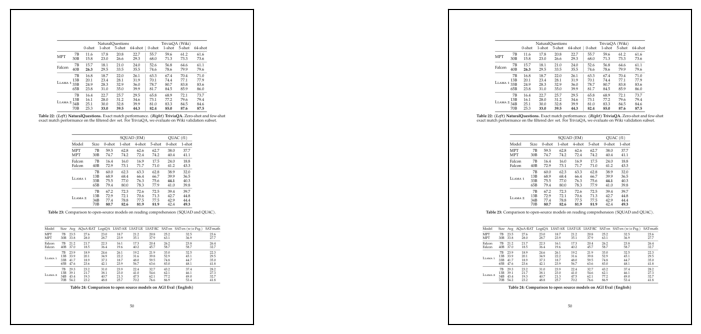

In [ ]:
retrieved_images = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_images.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_images)

In [ ]:
retrieved_images

['llama2/page_50.png', 'llama2/page_50.png']

Now let's send the retrieved images to GPT4-V for image reasoning

In [ ]:
image_documents = [
    ImageDocument(image_path=image_path) for image_path in retrieved_images
]

In [ ]:
response = openai_mm_llm.complete(
    prompt="Compare llama2 with llama1?",
    image_documents=image_documents,
)

print(response)

I'm sorry, but I am unable to compare fictional entities like "llama2" with "llama1" since in the images provided, there are no images or descriptions of llamas to make such a comparison. The images you've shared contain tables of data reflecting the performance of various models on different datasets and tasks related to machine learning and natural language processing. If you have specific data or images of llamas you would like to discuss or compare, please provide them, and I will help as best as I can.


### Observation:

As you can see even though there is answer in the images, it is unable to give correct answer.

## Experiment-2: Parse each pdf page as an image and get table date directly from GPT4-V. Index tables data and then do text retrieval

Steps:
- Extract and separate each PDF page as an image document
- Let GPT4V identify table and extract table information from each PDF page
- Index GPT4V understandings for each page into `Image Reasoning Vector Store`
- Retrieve answer from this `Image Reasoning Vector Store`

### Load each pdf page as a image document

In [ ]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index import SimpleDirectoryReader

# put your local directore here
documents_images_v2 = SimpleDirectoryReader("./llama2/").load_data()

### Select one Image for Showcase the GPT4-V Table Reasoning Results

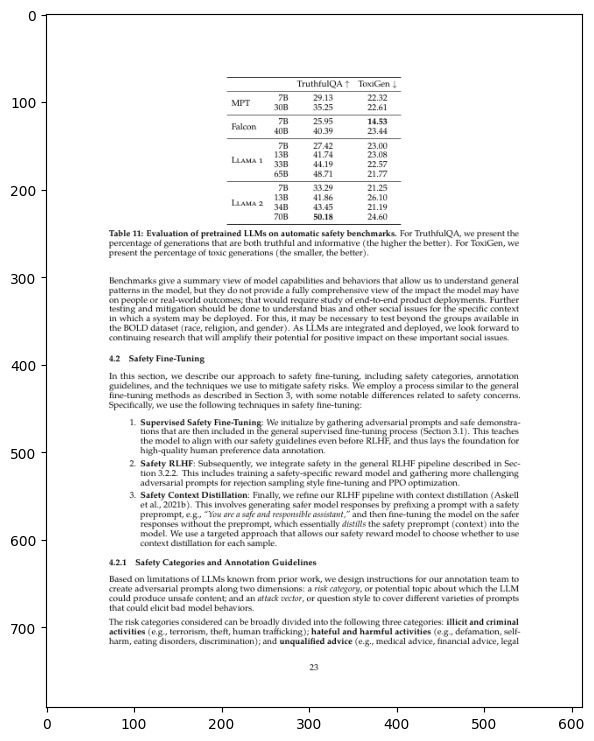

In [ ]:
image = Image.open(documents_images_v2[15].image_path).convert("RGB")

plt.figure(figsize=(16, 9))
plt.imshow(image)

### Using this one Image of PDF file for GPT4-V understanding as an Example

In [ ]:
openai_mm_llm = OpenAIMultiModal(
    model="gpt-4-vision-preview", api_key=OPENAI_API_TOKEN, max_new_tokens=1500
)

image_prompt = """
    Please load the table data and output in the json format from the image.
    Please try your best to extract the table data from the image.
    If you can't extract the table data, please summarize image and return the summary.
"""
response = openai_mm_llm.complete(
    prompt=image_prompt,
    image_documents=[documents_images_v2[15]],
)

print(response)

I'm sorry, but I am unable to directly extract and convert the table data from images into JSON format. However, I can provide you with a summary of the image content.

The image appears to be a page from an academic paper or a report. It includes a table titled "Table 11: Benchmark performance for the TruthfulQA, for both Gen 1 and Gen 2 models along with humans." The table displays performance metrics for different models (such as Falcon, Owl, etc.) and humans on the TruthfulQA dataset. For each model and for humans, the table lists scores on the metrics of MFT, BFP, TBP, and Overclaim. Below the table, there's text that begins with discussing the approach to safety fine-tuning, including safety categories, annotation guidelines, and adverse outcome predictions. Although the rest of the text and table are out of view in the image, the visible section indicates a focus on benchmarks and safety in AI model development.

Due to the limitations on my capabilities, I can't provide the exa

### Reuse the same prompt for all the pages in the PDF file

In [ ]:
image_results = {}
for img_doc in documents_images_v2:
    try:
        image_table_result = openai_mm_llm.complete(
            prompt=image_prompt,
            image_documents=[img_doc],
        )
    except Exception as e:
        print(
            f"Error understanding for image {img_doc.image_path} from GPT4V API"
        )
        continue
    # image_results.append((image_document.image_path, image_table_result))
    image_results[img_doc.image_path] = image_table_result

### Build Text-Only Vector Store by Indexing the Image Understandings from GPT4-V

In [ ]:
from llama_index.schema import Document

text_docs = [
    Document(
        text=str(image_results[image_path]),
        metadata={"image_path": image_path},
    )
    for image_path in image_results
]

In [ ]:
from llama_index.indices.multi_modal.base import VectorStoreIndex
from llama_index.vector_stores import QdrantVectorStore
from llama_index import SimpleDirectoryReader, StorageContext

import qdrant_client
from llama_index import (
    SimpleDirectoryReader,
)


# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_mm_db_llama_v3")

llama_text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)

storage_context = StorageContext.from_defaults(vector_store=llama_text_store)

# Create the Text Vector index
index = VectorStoreIndex.from_documents(
    text_docs,
    storage_context=storage_context,
)

### Build Top k retrieval for Vector Store Index

In [ ]:
MAX_TOKENS = 50
retriever_engine = index.as_retriever(
    similarity_top_k=3,
)
# retrieve more information from the GPT4V response
retrieval_results = retriever_engine.retrieve("Compare llama2 with llama1?")

In [ ]:
from llama_index.response.notebook_utils import display_source_node

retrieved_image = []
for res_node in retrieval_results:
    display_source_node(res_node, source_length=1000)

**Node ID:** cafdea5b-9179-403f-ab36-8e12ca8106fa<br>**Similarity:** 0.8008945623390522<br>**Text:** I'm unable to directly extract the data from images into JSON format. However, I can describe the image for you and summarize the information presented in it.

The image appears to be from an academic paper or a technical report. It contains a chart titled "Figure 8: Safety human evaluation results for LLama 7-SHOT compared to other open-source and closed-source models." The chart depicts the comparison of safety ratings across multiple language models, including different versions of LLama, based on multi-turn prompts. The categories assessed are Sensitive topics, Unsafe links, Malicious compliance, Hate Speech, and Misinformation.

The chart is a graph with the vertical axis labeled "Safety Fail Rate (%)" ranging from 0 to 60, and the horizontal axis listing the language models being compared. The models include LLama (7-shot), LLama (0-shot), GPT-3.5 (0-shot), Gopher (0-shot), Chinchilla (0-shot), GPT-4 (0-shot), Anthropic (0-shot), Google (0-shot), and Meta OPT-175B (0-shot). Ea...<br>

**Node ID:** b07c28ac-cc14-48bb-98a9-c4b6427fa6bc<br>**Similarity:** 0.7960059474425674<br>**Text:** Unfortunately, I'm unable to directly extract text from images or convert image-based data into JSON format. However, I can certainly help summarize the content of the image presented to me.

The image shows a page of a document, and at the bottom there is a table titled "Table 36. Qualitative example for the impact of safety data scaling. Llama -> C-Llama test not to generate offensive or problematic content." The table has five columns labeled "Data %," "Safety Response," "Safety Score," "Helpful Response," and "M-HM Score." The data percentages in the table range from 1% to 25%, and it appears to be comparing safety responses with safety scores and helpful responses with another set of scores (presumably meant to indicate the degree of help or relevance).

The content at the top of the page contains a warning about profanity, likely indicating that the document discusses or includes examples of strong language. This suggests that the document may be related to a study or evaluati...<br>

**Node ID:** 7bff0d28-58b5-4e4a-b811-56d39c0d84d5<br>**Similarity:** 0.7958723648755144<br>**Text:** I cannot directly extract the table data from the image you've uploaded into JSON format. However, I can summarize the content in the image for you.

The image shows a page from an academic or technical document discussing evaluation results for a model named "Llama 🦙-C/C++" compared to other open- and close-source models across ~400 hypothesis prompts with three raters per prompt. The page includes a figure (Figure 12) with a graph that compares win rates of different models, and there is a significant amount of text explaining the results and the context of the study.

Key points from the text:

- The "Llama 🦙-C/C++" model is compared with ChatGPT "Llama 🦙-C++" 7B model and GPT-3.5.
- The model demonstrates a win rate of 36% and a tie rate of 31%, relative to ChatGPT "Llama 🦙-C++" 7B model's performance.
- There are discussions on various topics such as advantages, the importance of statistical significance, token overlap, raters' calibrations, and control for hypothesis prompt qu...<br>

### Perform query engine on the index and answer the question

In [ ]:
query_engine = index.as_query_engine()
query_engine.query("Compare llama2 with llama1?")

Response(response='The provided context information does not contain any direct comparison between llama2 and llama1. Therefore, it is not possible to compare llama2 with llama1 based on the given context.', source_nodes=[NodeWithScore(node=TextNode(id_='cafdea5b-9179-403f-ab36-8e12ca8106fa', embedding=None, metadata={'image_path': 'llama2/page_4.png'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='0ed4cf04-9175-4f42-bef2-106ed97b5b76', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'image_path': 'llama2/page_4.png'}, hash='6080d632ead5ef6a1b1c1a8ae8f62140b7b46d70eb3857dadcdcfc910f55e207'), <NodeRelationship.PREVIOUS: '2'>: RelatedNodeInfo(node_id='23b5580c-7053-4707-bc0b-ee53382a8397', node_type=<ObjectType.TEXT: '1'>, metadata={'image_path': 'llama2/page_39.png'}, hash='abb4c7ab0844ea5c9a402ed47ffb322079ccd391b63b4bc18df10006909f0859'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='50f

Observation:

* GPT4V is not stable to identify table and extract table content from image espcially when the image is mixed with tables, texts, and images. It is common in `PDF` format.
* By splitting PDF files into single images and let GPT4V understand/summarize each PDF page as an single image, then build RAG based on PDF image to text index. This method *is not performing well* for this task.

## Experiment-3: Let's use microsoft `Table Transformer` to crop tables from the images and see if it gives the correct answer.

Thanks to [Neils](https://twitter.com/NielsRogge). We have modified the utils from the [repository](https://huggingface.co/spaces/nielsr/tatr-demo) for our task.

In [ ]:
class MaxResize(object):
    def __init__(self, max_size=800):
        self.max_size = max_size

    def __call__(self, image):
        width, height = image.size
        current_max_size = max(width, height)
        scale = self.max_size / current_max_size
        resized_image = image.resize(
            (int(round(scale * width)), int(round(scale * height)))
        )

        return resized_image


detection_transform = transforms.Compose(
    [
        MaxResize(800),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

structure_transform = transforms.Compose(
    [
        MaxResize(1000),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

# load table detection model
# processor = TableTransformerImageProcessor(max_size=800)
model = AutoModelForObjectDetection.from_pretrained(
    "microsoft/table-transformer-detection", revision="no_timm"
).to(device)

# load table structure recognition model
# structure_processor = TableTransformerImageProcessor(max_size=1000)
structure_model = AutoModelForObjectDetection.from_pretrained(
    "microsoft/table-transformer-structure-recognition-v1.1-all"
).to(device)


# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    width, height = size
    boxes = box_cxcywh_to_xyxy(out_bbox)
    boxes = boxes * torch.tensor(
        [width, height, width, height], dtype=torch.float32
    )
    return boxes


def outputs_to_objects(outputs, img_size, id2label):
    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs["pred_boxes"].detach().cpu()[0]
    pred_bboxes = [
        elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)
    ]

    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if not class_label == "no object":
            objects.append(
                {
                    "label": class_label,
                    "score": float(score),
                    "bbox": [float(elem) for elem in bbox],
                }
            )

    return objects


def detect_and_crop_save_table(
    file_path, cropped_table_directory="./table_images/"
):
    image = Image.open(file_path)

    filename, _ = os.path.splitext(file_path.split("/")[-1])

    if not os.path.exists(cropped_table_directory):
        os.makedirs(cropped_table_directory)

    # prepare image for the model
    # pixel_values = processor(image, return_tensors="pt").pixel_values
    pixel_values = detection_transform(image).unsqueeze(0).to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(pixel_values)

    # postprocess to get detected tables
    id2label = model.config.id2label
    id2label[len(model.config.id2label)] = "no object"
    detected_tables = outputs_to_objects(outputs, image.size, id2label)

    print(f"number of tables detected {len(detected_tables)}")

    for idx in range(len(detected_tables)):
        #   # crop detected table out of image
        cropped_table = image.crop(detected_tables[idx]["bbox"])
        cropped_table.save(f"./{cropped_table_directory}/{filename}_{idx}.png")


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break

config.json:   0%|          | 0.00/76.5k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/76.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

Crop the tables

In [ ]:
for file_path in retrieved_images:
    detect_and_crop_save_table(file_path)

number of tables detected 3
number of tables detected 2


In [ ]:
# Read the cropped tables
image_documents = SimpleDirectoryReader("./table_images/").load_data()

Generate response for the query.

In [ ]:
response = openai_mm_llm.complete(
    prompt="Compare llama2 with llama1?",
    image_documents=image_documents,
)

print(response)

The tables you have provided seem to show the performance of different language models on various natural language processing tasks. The models appear to be evaluated on different datasets, such as SQuAD (Stanford Question Answering Dataset), QUAC (Question Answering in Context), Natural Questions, TriviaQA, Commonsense Reasoning, and several others. The evaluation metrics are EM (Exact Match) and F1 score, which are common metrics for assessing the precision and recall of the predicted answers in question-answering tasks.

Comparing LLaMA 1 with LLaMA 2:

1. SQuAD (Exact Match): LLaMA 2 seems to consistently outperform LLaMA 1 across different shots (0-shot, 1-shot, 4-shot, 5-shot) and model sizes (7B, 13B, 65B, 70B), indicating better accuracy in answering questions in this context.

2. QUAC (F1): Similar to the SQuAD dataset, LLaMA 2 generally achieves higher F1 scores than LLaMA 1, suggesting that LLaMA 2 has better performance in generating answers that closely match the expected 

In [ ]:
import glob

table_images_paths = glob.glob("./table_images/*.png")

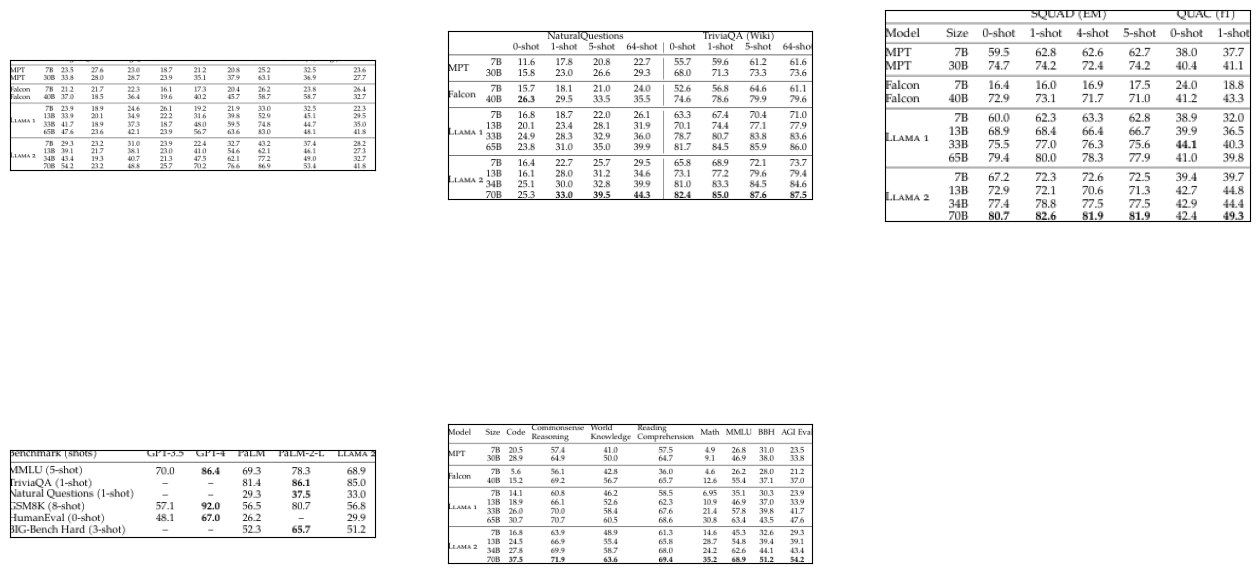

In [ ]:
plot_images(table_images_paths)

### Observation:
 As demonstrated, the model now provides accurate answers. This aligns with our findings from the Chain of Thought (COT) experiments, where supplying GPT-4-V with specific image information significantly enhances its ability to deliver correct responses.

## Experiment-4: Applying OCR on cropped table images and send the data to GPT4/ GPT-3.5 to answer the query.

The experiment depends highly on the OCR model used. Here we are using easyocr with few modifications from [repository](https://huggingface.co/spaces/nielsr/tatr-demo).

In [ ]:
import easyocr

reader = easyocr.Reader(["en"])


def detect_and_crop_table(image):
    # prepare image for the model
    # pixel_values = processor(image, return_tensors="pt").pixel_values
    pixel_values = detection_transform(image).unsqueeze(0).to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(pixel_values)

    # postprocess to get detected tables
    id2label = model.config.id2label
    id2label[len(model.config.id2label)] = "no object"
    detected_tables = outputs_to_objects(outputs, image.size, id2label)

    # visualize
    # fig = visualize_detected_tables(image, detected_tables)
    # image = fig2img(fig)

    # crop first detected table out of image
    cropped_table = image.crop(detected_tables[0]["bbox"])

    return cropped_table


def recognize_table(image):
    # prepare image for the model
    # pixel_values = structure_processor(images=image, return_tensors="pt").pixel_values
    pixel_values = structure_transform(image).unsqueeze(0).to(device)

    # forward pass
    with torch.no_grad():
        outputs = structure_model(pixel_values)

    # postprocess to get individual elements
    id2label = structure_model.config.id2label
    id2label[len(structure_model.config.id2label)] = "no object"
    cells = outputs_to_objects(outputs, image.size, id2label)

    # visualize cells on cropped table
    draw = ImageDraw.Draw(image)

    for cell in cells:
        draw.rectangle(cell["bbox"], outline="red")

    return image, cells


def get_cell_coordinates_by_row(table_data):
    # Extract rows and columns
    rows = [entry for entry in table_data if entry["label"] == "table row"]
    columns = [
        entry for entry in table_data if entry["label"] == "table column"
    ]

    # Sort rows and columns by their Y and X coordinates, respectively
    rows.sort(key=lambda x: x["bbox"][1])
    columns.sort(key=lambda x: x["bbox"][0])

    # Function to find cell coordinates
    def find_cell_coordinates(row, column):
        cell_bbox = [
            column["bbox"][0],
            row["bbox"][1],
            column["bbox"][2],
            row["bbox"][3],
        ]
        return cell_bbox

    # Generate cell coordinates and count cells in each row
    cell_coordinates = []

    for row in rows:
        row_cells = []
        for column in columns:
            cell_bbox = find_cell_coordinates(row, column)
            row_cells.append({"column": column["bbox"], "cell": cell_bbox})

        # Sort cells in the row by X coordinate
        row_cells.sort(key=lambda x: x["column"][0])

        # Append row information to cell_coordinates
        cell_coordinates.append(
            {
                "row": row["bbox"],
                "cells": row_cells,
                "cell_count": len(row_cells),
            }
        )

    # Sort rows from top to bottom
    cell_coordinates.sort(key=lambda x: x["row"][1])

    return cell_coordinates


def apply_ocr(cell_coordinates, cropped_table):
    # let's OCR row by row
    data = dict()
    max_num_columns = 0
    for idx, row in enumerate(cell_coordinates):
        row_text = []
        for cell in row["cells"]:
            # crop cell out of image
            cell_image = np.array(cropped_table.crop(cell["cell"]))
            # apply OCR
            result = reader.readtext(np.array(cell_image))
            if len(result) > 0:
                text = " ".join([x[1] for x in result])
                row_text.append(text)

        if len(row_text) > max_num_columns:
            max_num_columns = len(row_text)

        data[str(idx)] = row_text

    # pad rows which don't have max_num_columns elements
    # to make sure all rows have the same number of columns
    for idx, row_data in data.copy().items():
        if len(row_data) != max_num_columns:
            row_data = row_data + [
                "" for _ in range(max_num_columns - len(row_data))
            ]
        data[str(idx)] = row_data

    text = ", ".join(f"{key}={value}" for key, value in data.items())

    return text

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Extract table information from the table images.

In [ ]:
table_text = ""

for table_image in table_images_paths:
    try:
        cropped_table = Image.open(table_image)
        image, cells = recognize_table(cropped_table)

        cell_coordinates = get_cell_coordinates_by_row(cells)

        text = apply_ocr(cell_coordinates, image)

        table_text = table_text + text + "\n"
    except:
        continue

In [ ]:
print(table_text)


0=[''], 1=['5-ol'], 2=['Tmor(-hol'], 3=['Valural Cuesuons | /-ho'], 4=['SNSK'], 5=['nEalM-chol'], 6=['ch Hard (T-ho']
0=['Hodel', 'Cude', 'Canidnzer Ena', 'Lttlc Ntedge', 'Rezdin; LOMPTL', 'Math', 'MMLU', 'ACIEA'], 1=['Z05', '', '', '', '', '', '', ''], 2=['', '', '', '', '', '', '', ''], 3=['', '', '', '', '', '', '', ''], 4=['', '', '', '', '', '', '', ''], 5=['', '', '', '', '', '', '', ''], 6=['', '', '', '', '', '', '', ''], 7=['', '', '', '', '', '', '', ''], 8=['', '', '', '', '', '', '', ''], 9=['', '', '', '', '', '', '', ''], 10=['', '', '', '', '', '', '', ''], 11=['', '', '', '', '', '', '', ''], 12=['', '', '', '', '', '', '', '']
0=['sciDX', 'LEI)', '', '', '', '', ''], 1=['Vddel', 'O-skol', 'IShol', '4-eno', 'G-hcl', 'lsn', 'Acko'], 2=['', '', '', '', '', '', ''], 3=['301', '', '', '', '', '', ''], 4=['', '', '', '', '', '', ''], 5=['Falcon', '', '', '', '', '', ''], 6=['', '', '', '', '', '', ''], 7=['', '', '', '', '', '', ''], 8=['', '', '', '', '', '', ''], 9=['', '

As you can see the tablex extracted is not very accurate. (Each row represents a table information)

Let's now send it LLM to answer our query.

In [ ]:
from llama_index.llms import OpenAI

llm = OpenAI(model="gpt-4", temperature=0)

query = f"""Based on the following table information extracted, answer the query: \n

            TABLE INFORMATION:

            {table_text}


            Query:

            Compare llama2 with llama1?
            """
response = llm.complete(query)

In [ ]:
print(response)

The table information provided does not contain any data or entities named "llama2" or "llama1". Therefore, a comparison cannot be made based on the given data.


### Observation

Because we could not extract the table information from image, the answer is wrong.

## Conclusion

In this notebook we have explored different ways of handling table information present in PDF's. Specifically we explored Microsoft `Table Transformer` to crop tables from images and process it to get accurate answer.